# Basics of Mobile Robotics: Project - Part Global Nav


# Author : PB

In [277]:
import numpy as np
import control as ct
import control.optimal as opt
import matplotlib.pyplot as plt
import scipy.optimize as scopt
from src import model

ModuleNotFoundError: No module named 'src'

## GLOBAL NAVIGATION IMPLEMENTATION

I decided to develop and test my global navigation on this notebook before implementing it in the folder

In [263]:
# USE OF MPC

#	X    -----------------      u       ---------
#	---> | MPC Regulator |------------> | Plant |----------> Output
#	|    -----------------              ---------   |
#	|           ^                                   |
#	|           | (xs, us)                          |
#	|           |                                   |
#	|           |       ------------                |
#	|           --------| target   |<----------------
#	|                   | selector |<-- reference   |
#	|                   ------------                |
#	|                                               |
#	-------------------------------------------------

Initial parameters

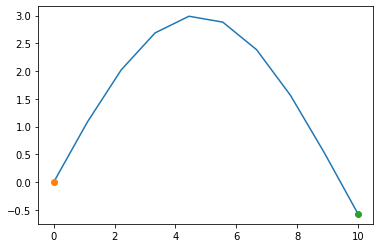

In [275]:
# initialization block
Tf = 10
min_velocity = 0
max_velocity = 1
min_deviation_phi = -1
max_deviation_phi = 1

tps = np.linspace(0, Tf, Tf)


#create the data point
xaxis = np.linspace(0.0, 10.0, num=10)
yaxis = 3*np.sin(xaxis/3)

#plt.plot(tps, 3*np.sin(tps/3))
plt.plot(xaxis, yaxis)

x0 = [0., 0., 0.7]; u0 = [np.sqrt((tps[1]-tps[0])**2 + (np.sin(tps[1])-np.sin(tps[0]))**2), (tps[1]-tps[0])/Tf]
xf = [tps[-1], 3*np.sin(tps[-1]/3), 0.]; uf = [10., 0.]

def lafonc(x):
    return 3*np.sin(x/3)

Q = np.array([[10, 1, 0],[1, 10, 0], [0, 0, 0.1]])          # don't turn too sharply
R = np.diag([0.1, 0.1])               # keep inputs small
P = np.diag([10, 10, 0])   # get close to final point


plt.plot(x0[0], x0[1], marker="o")
plt.plot(xf[0], xf[1], marker="o")

Useful functions

In [265]:
def vehicle_update(t, x, u, params):
    # Get the parameters for the model
    l = params.get('wheelbase', 3.)         # vehicle wheelbase
    #phimax = params.get('maxsteer', 0.5)    # max steering angle (rad)
    
    # Saturate the steering input
    phi = np.clip(u[1], min_deviation_phi, max_deviation_phi)

    # Return the derivative of the state
    return np.array([
        np.cos(x[2]) * u[0],            # xdot = cos(theta) v
        np.sin(x[2]) * u[0],            # ydot = sin(theta) v
        (u[0] / l) * np.tan(phi)        # thdot = v/l tan(phi)
    ])



def vehicle_output(t, x, u, params):
    return x                            # return x, y, theta (full state)

# Define the vehicle steering dynamics as an input/output system
vehicle = ct.NonlinearIOSystem(
    vehicle_update, vehicle_output, states=3, name='vehicle',
    inputs=('v', 'phi'), outputs=('x', 'y', 'theta'))

First iteration test

Summary statistics:
* Cost function calls: 77
* Constraint calls: 93
* System simulations: 140
* Final cost: 3070.279254063228


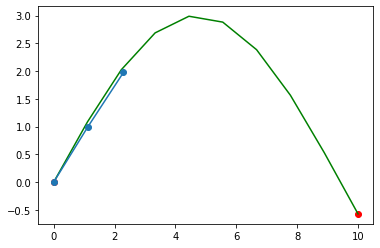

[[ 1.          1.00000001  1.        ]
 [ 0.06239319  0.18262615 -1.00000001]]


In [266]:
LengthHorizon = 3

traj_cost = opt.quadratic_cost(vehicle, Q, R, x0=xf, u0=uf)
term_cost = opt.quadratic_cost(vehicle, P, 0, x0=xf)

def fun(x,u):
    return x[1]-3*np.sin(x[0]/3)
lb = -0.1
ub = 0.1

#constraints = [{"type": "ineq", "fun": lambda x: x[0] - 3*np.sin(x[1]/3)+2},{"type": "ineq", "fun": lambda x: -x[0] + 3*np.sin(x[1]/3)+2}]
constraints = [(scopt.NonlinearConstraint, fun, lb, ub), opt.input_range_constraint(vehicle, [min_velocity, min_deviation_phi], [max_velocity, max_deviation_phi]) ]
#constraints = []  

horizon = np.linspace(0, LengthHorizon, LengthHorizon, endpoint=True)
result = opt.solve_ocp(vehicle, horizon, x0, traj_cost, constraints, terminal_cost=term_cost, initial_guess=u0, log=False)

# Simulate the system dynamics (open loop)
resp = ct.input_output_response(
    vehicle, horizon, result.inputs, x0,
    t_eval=np.linspace(0, LengthHorizon, LengthHorizon))
t, y, u = resp.time, resp.outputs, resp.inputs

# Plot
plt.plot(x0[0], x0[1], 'ro', xf[0], xf[1], 'ro')
plt.plot(tps, 3*np.sin(tps/3), 'g')
plt.plot(y[0], y[1], 'o-')
plt.show()
print(u)

Optimization loop

step 0
Summary statistics:
* Cost function calls: 77
* Constraint calls: 93
* System simulations: 140
* Final cost: 3070.279254063228
step 1


c:\Users\paul\AppData\Local\Programs\Python\Python310\lib\site-packages\control\optimal.py:862: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Positive directional derivative for linesearch
  warnings.warn(


Summary statistics:
* Cost function calls: 522
* Constraint calls: 577
* System simulations: 858
* Final cost: 2037.7338698043588
step 2


c:\Users\paul\AppData\Local\Programs\Python\Python310\lib\site-packages\control\optimal.py:862: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Inequality constraints incompatible
  warnings.warn(


Summary statistics:
* Cost function calls: 926
* Constraint calls: 1006
* System simulations: 1437
* Final cost: 1242.1862409748478
step 3


c:\Users\paul\AppData\Local\Programs\Python\Python310\lib\site-packages\control\optimal.py:862: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Positive directional derivative for linesearch
  warnings.warn(


Summary statistics:
* Cost function calls: 112
* Constraint calls: 130
* System simulations: 189
* Final cost: 584.6134643402813
step 4
Summary statistics:
* Cost function calls: 203
* Constraint calls: 229
* System simulations: 336
* Final cost: 194.03304661132915


c:\Users\paul\AppData\Local\Programs\Python\Python310\lib\site-packages\control\optimal.py:862: UserWarning: unable to solve optimal control problem
scipy.optimize.minimize returned Positive directional derivative for linesearch
  warnings.warn(


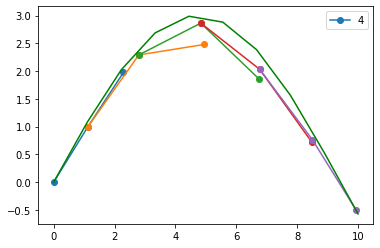

In [267]:
# still working on this part

Xfinal = np.zeros((Tf,3))

LengthHorizon = 3
eps = 0.5
y = np.zeros((3,LengthHorizon))

def fun(x,u):
    return x[1]-3*np.sin(x[0]/3)
lb = -0.1
ub = 0.1

ite = 0

while (abs(y[0,LengthHorizon-1]-xf[0])>eps or abs(y[1,LengthHorizon-1]-xf[1])>eps) and ite<15:
    print("step %s" % ite)
    if (ite+LengthHorizon<Tf):
        index = ite+LengthHorizon
    else:
        index = Tf-1

    xgoal = [tps[index], 3*np.sin(tps[index]/3), (tps[index]-tps[index-1])/Tf]
    traj_cost = opt.quadratic_cost(vehicle, Q, R, x0=xf, u0=uf)
    term_cost = opt.quadratic_cost(vehicle, P, 0, x0=xf)
     

    constraints = [(scopt.NonlinearConstraint, fun, lb, ub), opt.input_range_constraint(vehicle, [min_velocity, min_deviation_phi], [max_velocity, max_deviation_phi]) ]
    #constraints = []

    horizon = np.linspace(0, LengthHorizon, LengthHorizon, endpoint=True)
    result = opt.solve_ocp(vehicle, horizon, x0, traj_cost, constraints,terminal_cost=term_cost, initial_guess=u0)

    # Simulate the system dynamics (open loop)
    resp = ct.input_output_response(
        vehicle, horizon, result.inputs, x0,
        t_eval=np.linspace(0, LengthHorizon, LengthHorizon))
    t, y, u = resp.time, resp.outputs, resp.inputs
    
    x0 = y[:,1]

    Xfinal[ite,:] = y[:,1]
    plt.plot(y[0], y[1], 'o-')
    plt.legend("%s" %ite)
    ite += 1

for j in range(LengthHorizon):
    Xfinal[Tf-LengthHorizon+j,:] = y[:,len(y)-LengthHorizon+j]

plt.plot(tps, 3*np.sin(tps/3), 'g')
#plt.plot(Xfinal[0:ite+LengthHorizon,0],Xfinal[0:ite+LengthHorizon,1],'yo--',linewidth=5.0)
plt.show()

Final plot

In [268]:
bool((abs(y[0,-1]-xf[0])>eps or abs(y[1,-1]-xf[1])>eps))
y

array([[ 6.7694041 ,  8.49651109,  9.93869426],
       [ 2.03231508,  0.7681551 , -0.50368822],
       [-0.67213466, -0.65766776, -0.77121036]])